Higgs search sandbox
---------------------------------

Event selection based on https://arxiv.org/abs/1802.04146

In [6]:
import os

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt

import uproot

In [7]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/data/"

In [8]:
datasets = {
    "GamGam": {
        "Data": [
            "data_A.GamGam",
            "data_B.GamGam",
            "data_C.GamGam",
            "data_D.GamGam"
        ],
        "MC": [
            ("mc_341081.ttH125_gamgam.GamGam", {"tag": "tt"}),
            ("mc_343981.ggH125_gamgam.GamGam", {"tag": "gg"}),
            ("mc_345041.VBFH125_gamgam.GamGam", {"tag": "VBF"}),
            ("mc_345318.WpH125J_Wincl_gamgam.GamGam", {"tag": "Wp"}),
            ("mc_345319.ZH125J_Zincl_gamgam.GamGam", {"tag": "Z"})

        ]
    }
}

In [44]:
def yield_files_with_meta(datasets, type_filter=None):
    if type_filter is None:
        type_filter = ["MC"]
    
    for process_name, process in datasets.items():
        print("Process: ", process_name)
        for type_name, thetype in process.items():
            print("Type: ", type_name)
            if type_name not in type_filter:
                continue
            for filedata in thetype:
                try:
                    filename, meta = filedata
                except ValueError:
                    filename = filedata
                    meta = {}
                print("File: ", filename)
                fullpath = os.path.join("root://", data_path, process_name, type_name, f"{filename}.root")
                yield (process_name, type_name, filename), fullpath

In [10]:
def dict_apply_mask(d, mask, fields=None):
    if fields is None:
        fields = d.keys()
    for f in fields:
        d[f] = d[f][mask]

In [11]:
def eta2tg_theta(eta):
    tg_theta = np.exp(-eta)
    tg_theta = 2*tg_theta**2/(1 - tg_theta**2)
    return tg_theta

In [12]:
def atlas_two_cosine(events, p1, p2):
    tg_theta_1 = eta2tg_theta(events[p1+b"_eta"])
    tg_theta_2 = eta2tg_theta(events[p2+b"_eta"])
    cos_delta_phi = np.cos(events[p2+b"_phi"] - events[p1+b"_phi"])
    return (cos_delta_phi + tg_theta_1*tg_theta_2)/np.sqrt((tg_theta_1**2 + 1)*(tg_theta_2**2 + 1))

In [13]:
def photon_filter(events):
    # macro_mask = True
    
    macro_events = {}
    micro_events = {}
    
    macro_events[b"photon_n"] = events[b"photon_n"]
    n_threshold = macro_events[b"photon_n"] >= 2
    macro_mask = n_threshold
    
    micro_events[b"photon_pt"] = events[b"photon_pt"][n_threshold]
    micro_events[b"photon_eta"] = events[b"photon_eta"][n_threshold]
    micro_events[b"photon_phi"] = events[b"photon_phi"][n_threshold]
    micro_events[b"photon_E"] = events[b"photon_E"][n_threshold]
    micro_events[b"photon_isTightID"] = events[b"photon_isTightID"][n_threshold]
    micro_events[b"photon_trigMatched"] = events[b"photon_trigMatched"][n_threshold]
    micro_events[b"photon_ptcone30"] = events[b"photon_ptcone30"][n_threshold]
    micro_events[b"photon_etcone20"] = events[b"photon_etcone20"][n_threshold]
    
    
    pts = micro_events[b"photon_pt"].argsort(ascending=False)
    row_indices = np.arange(pts.shape[0])
    lead_pts = pts[:, 0]
    sublead_pts = pts[:, 1]
    
    
    macro_events[b"photon_n"] = macro_events[b"photon_n"][n_threshold]
    macro_events[b"photon_lead_pt"] = micro_events[b"photon_pt"][row_indices, lead_pts]
    macro_events[b"photon_lead_eta"] = micro_events[b"photon_eta"][row_indices, lead_pts]
    macro_events[b"photon_lead_phi"] = micro_events[b"photon_phi"][row_indices, lead_pts]
    macro_events[b"photon_lead_E"] = micro_events[b"photon_E"][row_indices, lead_pts]
    macro_events[b"photon_lead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, lead_pts]
    macro_events[b"photon_lead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, lead_pts]
    macro_events[b"photon_lead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, lead_pts]
    macro_events[b"photon_lead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, lead_pts]
    macro_events[b"photon_sublead_pt"] = micro_events[b"photon_pt"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_eta"] = micro_events[b"photon_eta"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_phi"] = micro_events[b"photon_phi"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_E"] = micro_events[b"photon_E"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, sublead_pts]
    
    macro_filter = (  (macro_events[b"photon_lead_pt"] > 25000)
                    &
                      (macro_events[b"photon_sublead_pt"] > 25000)
                    &
                      (macro_events[b"photon_lead_isTightID"])
                    &
                      (macro_events[b"photon_sublead_isTightID"])
                    &
                      (macro_events[b"photon_lead_trigMatched"])
                    &
                      (macro_events[b"photon_sublead_trigMatched"])
                    & 
                      (macro_events[b"photon_lead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_lead_etcone20"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_etcone20"] < 0.065)
                    & 
                      (  (np.absolute(macro_events[b"photon_lead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_lead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_lead_eta"]) < 2.37)
                         )
                      )
                    & (  (np.absolute(macro_events[b"photon_sublead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_sublead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_sublead_eta"]) < 2.37)
                         )
                      )
                   )
    
    dict_apply_mask(macro_events, macro_filter)
    macro_mask[macro_mask] = macro_filter

    macro_events[b"h_mass"] = np.sqrt(2.*macro_events[b"photon_lead_E"]
                                        *macro_events[b"photon_sublead_E"]
                                        *(1. - atlas_two_cosine(macro_events, b"photon_lead", b"photon_sublead"))
                                     )
    
    mass_cutoff =   (macro_events[b"photon_lead_E"]/macro_events[b"h_mass"] > 0.35) \
                  & (macro_events[b"photon_sublead_E"]/macro_events[b"h_mass"] > 0.25) \
                  & (macro_events[b"h_mass"] >= 105000.) \
                  & (macro_events[b"h_mass"] <= 160000)
    
    dict_apply_mask(macro_events, mass_cutoff)
    macro_mask[macro_mask] = mass_cutoff
    
    return macro_events, macro_mask
#photon_filter(test_events)

In [36]:
def process_event_batch(events, bin_edges, weighted=False):
    filtered_photons, photon_macro_mask = photon_filter(events)
    h_masses = filtered_photons[b"h_mass"]/1000
    if weighted:
        total_weights = events[b"SumWeights"][0]
        x_section = events[b"XSection"][0]
        weights = (  events[b"mcWeight"]
                   * events[b'scaleFactor_PILEUP'] 
                   * events[b'scaleFactor_ELE'] 
                   * events[b'scaleFactor_MUON'] 
                   * events[b'scaleFactor_PHOTON'] 
                   * events[b'scaleFactor_TAU'] 
                   * events[b'scaleFactor_BTAG'] 
                   * events[b'scaleFactor_LepTRIGGER'] 
                   * events[b'scaleFactor_PhotonTRIGGER']
                  )[photon_macro_mask]/total_weights*x_section
    else:
        weights = None
    hist = np.histogram(h_masses, bin_edges, weights=weights, density=False)[0]
    return hist
#process_event_batch(test_events, bin_edges)

In [37]:
bin_edges = np.linspace(105., 160., 55, dtype=np.float64)

In [61]:
def histogram_per_file(datasets, binedges, type_filter):
    entrysteps = 100000
    
    histograms = {}
    for (process, thetype, name), fullpath in yield_files_with_meta(datasets, type_filter):
        label = f"{process}:{thetype}:{name}"
        histograms[label] = np.zeros((bin_edges.shape[0] - 1,), dtype=np.float64)
        thehist = histograms[label]
        is_mc = ("mc" == thetype.lower())
        with uproot.open(fullpath) as f:
            total_events = f["mini"].numentries
            print("Total Num Events: ", total_events)
            for i, events in enumerate(f["mini"].iterate(["*"], entrysteps=entrysteps)):
                print("Processing: ", (i+1)*entrysteps)
                thehist += process_event_batch(events, bin_edges, weighted=is_mc)
    return histograms

In [63]:
mc_hists = histogram_per_file(datasets, bin_edges, ["MC"])

Process:  GamGam
Type:  Data
Type:  MC
File:  mc_341081.ttH125_gamgam.GamGam
Total Num Events:  576491
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
File:  mc_343981.ggH125_gamgam.GamGam
Total Num Events:  1054711
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
Processing:  700000
Processing:  800000
Processing:  900000
Processing:  1000000
Processing:  1100000
File:  mc_345041.VBFH125_gamgam.GamGam
Total Num Events:  497468
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
File:  mc_345318.WpH125J_Wincl_gamgam.GamGam
Total Num Events:  113765
Processing:  100000
Processing:  200000
File:  mc_345319.ZH125J_Zincl_gamgam.GamGam
Total Num Events:  230900
Processing:  100000
Processing:  200000
Processing:  300000


In [64]:
data_hists = histogram_per_file(datasets, bin_edges, ["Data"])

Process:  GamGam
Type:  Data
File:  data_A.GamGam
Total Num Events:  430344
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
File:  data_B.GamGam
Total Num Events:  1528717
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
Processing:  700000
Processing:  800000
Processing:  900000
Processing:  1000000
Processing:  1100000
Processing:  1200000
Processing:  1300000
Processing:  1400000
Processing:  1500000
Processing:  1600000
File:  data_C.GamGam
Total Num Events:  2237187
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
Processing:  700000
Processing:  800000
Processing:  900000
Processing:  1000000
Processing:  1100000
Processing:  1200000
Processing:  1300000
Processing:  1400000
Processing:  1500000
Processing:  1600000
Processing:  1700000
Processing:  1800000
Processing:  1900000
Processing:

In [66]:
mc_hists

{'GamGam:MC:mc_341081.ttH125_gamgam.GamGam': array([0.00021376, 0.00020169, 0.00028087, 0.00031466, 0.00041047,
        0.00047743, 0.00051634, 0.00053082, 0.00054596, 0.00049268,
        0.00049751, 0.00055116, 0.00057144, 0.00046369, 0.00059347,
        0.00049488, 0.00053157, 0.0005724 , 0.00058028, 0.00065371,
        0.00060802, 0.00056904, 0.00057731, 0.00051922, 0.00057965,
        0.00054836, 0.00055537, 0.00049814, 0.00050239, 0.00048066,
        0.00041189, 0.00047932, 0.00053871, 0.00045519, 0.00044849,
        0.000489  , 0.00044088, 0.00049974, 0.00042528, 0.00044202,
        0.00039473, 0.00036565, 0.00039008, 0.00033042, 0.0002645 ,
        0.00036574, 0.00034642, 0.00033039, 0.00030735, 0.00035451,
        0.0002511 , 0.00033525, 0.00037698, 0.00030359]),
 'GamGam:MC:mc_343981.ggH125_gamgam.GamGam': array([0.00026984, 0.00026036, 0.00033549, 0.00044099, 0.00058159,
        0.00074253, 0.00083842, 0.00082502, 0.00087869, 0.00083646,
        0.00072421, 0.00069466, 0.0006

In [67]:
data_hists

{'GamGam:Data:data_A.GamGam': array([16., 16., 11., 18., 12., 22., 13., 11., 18., 16.,  8., 10., 11.,
        10., 20., 13., 10., 11., 11., 14., 13.,  6., 13.,  9., 14.,  8.,
        10.,  4., 17.,  6., 10.,  7.,  8.,  8., 10., 12.,  4.,  5.,  9.,
         7.,  9., 11.,  8.,  8.,  6.,  7., 11.,  2.,  7.,  4.,  7.,  6.,
        11.,  1.]),
 'GamGam:Data:data_B.GamGam': array([67., 54., 57., 59., 48., 63., 63., 67., 48., 54., 49., 40., 36.,
        36., 48., 46., 44., 32., 50., 33., 53., 36., 35., 40., 32., 42.,
        36., 43., 25., 22., 41., 29., 35., 36., 39., 30., 22., 37., 25.,
        25., 28., 34., 20., 33., 25., 30., 32., 34., 21., 25., 23., 24.,
        23., 16.]),
 'GamGam:Data:data_C.GamGam': array([ 77.,  72., 109.,  86.,  82.,  79.,  70.,  68.,  67.,  79.,  78.,
         71.,  77.,  73.,  51.,  67.,  57.,  62.,  57.,  63.,  59.,  60.,
         46.,  56.,  58.,  34.,  56.,  51.,  45.,  51.,  53.,  46.,  45.,
         35.,  37.,  45.,  34.,  42.,  42.,  49.,  40.,  47.,  46.,

In [92]:
data_hist = sum(data_hists.values())

In [96]:
mc_hist = sum(mc_hists.values())

In [98]:
mc_hist.sum()

0.11286390700661286

In [99]:
data_hist.sum()

10335.0

In [100]:
bin_mid = (bin_edges[1:] + bin_edges[:-1])/2
bin_size = (bin_edges[1:] - bin_edges[:-1])

In [71]:
L = 1000

In [101]:
mc_hist

array([0.00120338, 0.0012559 , 0.00145287, 0.0016755 , 0.00205133,
       0.00233638, 0.002758  , 0.0028267 , 0.00296542, 0.00283627,
       0.0027956 , 0.0027123 , 0.00276485, 0.00255789, 0.00274605,
       0.0025998 , 0.0025946 , 0.00272886, 0.00293506, 0.00327095,
       0.0031788 , 0.00304698, 0.00296356, 0.0028209 , 0.00277534,
       0.00266323, 0.00248453, 0.00233496, 0.00227782, 0.00228732,
       0.00206258, 0.00202175, 0.0021308 , 0.00205563, 0.00191837,
       0.00187655, 0.00167713, 0.00177236, 0.00154955, 0.00161863,
       0.00150048, 0.0014971 , 0.00139741, 0.00136805, 0.00134152,
       0.00135155, 0.00132215, 0.00125212, 0.00125868, 0.00125199,
       0.00120665, 0.0011288 , 0.00127587, 0.00112707])

In [102]:
data_hist

array([290., 292., 320., 297., 252., 310., 274., 260., 254., 265., 254.,
       238., 228., 235., 238., 223., 206., 217., 232., 214., 223., 178.,
       190., 197., 201., 175., 208., 180., 174., 167., 183., 165., 155.,
       166., 171., 156., 128., 145., 136., 139., 138., 160., 132., 140.,
       140., 124., 127., 142., 116., 129., 109., 119., 128.,  95.])

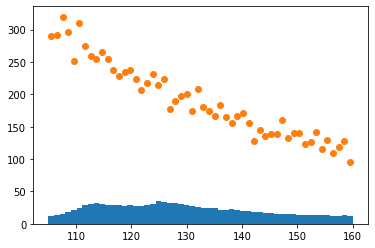

In [103]:
plt.bar(bin_mid, mc_hist*1000*10.6, width=bin_size, zorder=0)
plt.scatter(bin_mid, data_hist, zorder=1)

In [25]:
test_mc = uproot.open(os.path.join("root://", data_path, "GamGam", "MC", f"{datasets['GamGam']['MC'][0][0]}.root"))

In [27]:
test_data = uproot.open(os.path.join("root://", data_path, "GamGam", "Data", f"{datasets['GamGam']['Data'][0]}.root"))

In [28]:
test_data["mini"].keys()

[b'runNumber',
 b'eventNumber',
 b'channelNumber',
 b'mcWeight',
 b'scaleFactor_PILEUP',
 b'scaleFactor_ELE',
 b'scaleFactor_MUON',
 b'scaleFactor_PHOTON',
 b'scaleFactor_TAU',
 b'scaleFactor_BTAG',
 b'scaleFactor_LepTRIGGER',
 b'scaleFactor_PhotonTRIGGER',
 b'trigE',
 b'trigM',
 b'trigP',
 b'lep_n',
 b'lep_truthMatched',
 b'lep_trigMatched',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_E',
 b'lep_z0',
 b'lep_charge',
 b'lep_type',
 b'lep_isTightID',
 b'lep_ptcone30',
 b'lep_etcone20',
 b'lep_trackd0pvunbiased',
 b'lep_tracksigd0pvunbiased',
 b'met_et',
 b'met_phi',
 b'jet_n',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_jvt',
 b'jet_trueflav',
 b'jet_truthMatched',
 b'jet_MV2c10',
 b'photon_n',
 b'photon_truthMatched',
 b'photon_trigMatched',
 b'photon_pt',
 b'photon_eta',
 b'photon_phi',
 b'photon_E',
 b'photon_isTightID',
 b'photon_ptcone30',
 b'photon_etcone20',
 b'photon_convType',
 b'tau_n',
 b'tau_pt',
 b'tau_eta',
 b'tau_phi',
 b'tau_E',
 b'tau_isTightID',
 b'tau_tru

In [53]:
test_mc_events = next(test_mc["mini"].iterate(["mcWeight", "SumWeights", "scale*", "photon_*", "XSection"], entrystop=10))

In [54]:
test_data_events = next(test_data["mini"].iterate(["mcWeight", "SumWeights", "scale*", "photon_*", "XSection"], entrystop=10))

In [55]:
test["mini"].numentries

576491

In [56]:
test_mc_events.keys()

dict_keys([b'mcWeight', b'SumWeights', b'scaleFactor_PILEUP', b'scaleFactor_ELE', b'scaleFactor_MUON', b'scaleFactor_PHOTON', b'scaleFactor_TAU', b'scaleFactor_BTAG', b'scaleFactor_LepTRIGGER', b'scaleFactor_PhotonTRIGGER', b'photon_n', b'photon_truthMatched', b'photon_trigMatched', b'photon_pt', b'photon_eta', b'photon_phi', b'photon_E', b'photon_isTightID', b'photon_ptcone30', b'photon_etcone20', b'photon_convType', b'photon_pt_syst', b'XSection'])

In [57]:
test_mc_events[b"XSection"]

array([2.6433863e-06, 2.6433863e-06, 2.6433863e-06, 2.6433863e-06,
       2.6433863e-06, 2.6433863e-06, 2.6433863e-06, 2.6433863e-06,
       2.6433863e-06, 2.6433863e-06], dtype=float32)

In [84]:
total_weights = test_mc_events[b"SumWeights"][0]
x_section = test_mc_events[b"XSection"][0]
weights = (  test_mc_events[b"mcWeight"]
           * test_mc_events[b'scaleFactor_PILEUP'] 
           * test_mc_events[b'scaleFactor_ELE'] 
           * test_mc_events[b'scaleFactor_MUON'] 
           * test_mc_events[b'scaleFactor_PHOTON'] 
           * test_mc_events[b'scaleFactor_TAU'] 
           * test_mc_events[b'scaleFactor_BTAG'] 
           * test_mc_events[b'scaleFactor_LepTRIGGER'] 
           * test_mc_events[b'scaleFactor_PhotonTRIGGER']
          )/total_weights*x_section

In [91]:
weights

array([-4.1094459e-12, -3.5343677e-12, -4.1031982e-12,  3.7236720e-12,
        4.2147254e-12, -4.3056995e-12,  3.4625393e-12, -4.5628865e-12,
        6.1836135e-12, -5.2693930e-12], dtype=float32)

In [86]:
total_weights

485440.0

In [87]:
x_section

2.6433863e-06